In [1]:
# 1. Imports
import os
import json
import warnings
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import pearsonr
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint

# Suppress Hugging Face warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

2025-05-06 06:53:49.653185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746514429.850345      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746514429.905966      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/train.csv')
test_df = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/test.csv')
sample_submission = pd.read_csv('/kaggle/input/shl-intern-hiring-assessment/sample_submission.csv')

with open('/kaggle/input/transcripts/train_transcripts.json', 'r') as f:
    train_transcripts = json.load(f)
with open('/kaggle/input/transcripts/test_transcripts.json', 'r') as f:
    test_transcripts = json.load(f)

In [3]:
# 3. BERT Embeddings
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# 4. Audio Feature Extraction
def extract_audio_features(path):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.concatenate([
        np.mean(mfcc, axis=1),
        np.std(mfcc, axis=1),
        np.mean(chroma, axis=1),
        np.mean(zcr, axis=1),
        np.mean(spec_contrast, axis=1)
    ])
    return features

In [5]:
# 5. Build Features
def build_features(df, transcripts, audio_dir, is_train=True):
    features = []
    labels = []
    for _, row in df.iterrows():
        fname = row['filename']
        text = transcripts.get(fname, "")
        text_feat = get_bert_embedding(text)
        audio_feat = extract_audio_features(os.path.join(audio_dir, fname))
        combined_feat = np.concatenate([text_feat, audio_feat])
        features.append(combined_feat)
        if is_train:
            labels.append(row['label'])
    return (np.array(features), np.array(labels)) if is_train else np.array(features)

train_audio_dir = '/kaggle/input/shl-audio/train/train'
test_audio_dir = '/kaggle/input/shl-audio/test/test'

X, y = build_features(train_df, train_transcripts, train_audio_dir)
X_test = build_features(test_df, test_transcripts, test_audio_dir, is_train=False)

In [6]:
# 6. Scale Features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [7]:
# 7. Split Train-Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 8. Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 600),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'min_samples_split': randint(2, 10)
}

base_model = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(
    base_model, param_distributions=param_dist, n_iter=20,
    cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)
random_search.fit(X_train, y_train)

model = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Train RMSE: 0.1060
Train Pearson Correlation: 0.9968
Validation RMSE: 0.8260
Validation Pearson Correlation: 0.7342


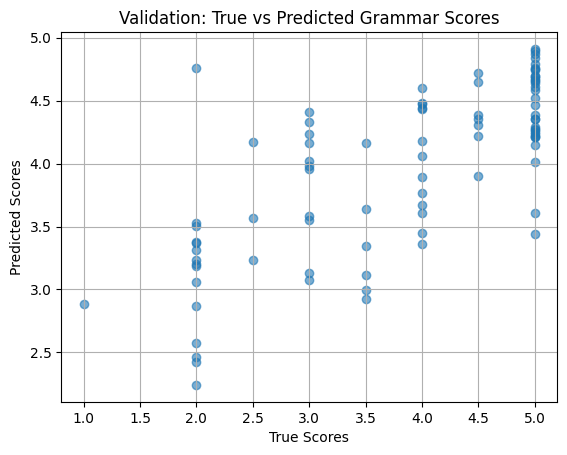

In [9]:
# 9. Evaluation
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
train_pearson, _ = pearsonr(y_train, train_preds)
val_pearson, _ = pearsonr(y_val, val_preds)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train Pearson Correlation: {train_pearson:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation Pearson Correlation: {val_pearson:.4f}")

plt.scatter(y_val, val_preds, alpha=0.6)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("Validation: True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()

In [10]:
# 10. Submission
submission = sample_submission.copy()
submission['label'] = model.predict(X_test)
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
